# Simultaneous Localization and Mapping

In robotics, the SLAM problem is to build a map of an uncertain environment while also estimating the state of the robot. Here, we consider the case where the system and observation dynamics are described by linear systems, and the noise in the system is additive white Gaussian noise. In this case, closed-form solutions may be obtained using the well-known Kalman Filter and/or maximum likelihood estimation.

## Part I

First, we consider the case where we represent the landmark positions with state variables. Suppose the robot is moving in the plane and there are three landmarks. There are 4 state variables for the robot position and velocity and 6 state variables for the positions of the landmarks.

$$ s_{t+1|t} = F s_{t|t}+ B u_t + w_t $$
$$ w_t \sim N(0,Q) $$
$$ o_t = H s_t + v_t $$
$$ v_t \sim N(0,R) $$

The Kalman filter updates are: \\
A priori updates:
$$ \bar{s}_{t+1|t} = F \bar{s}_{t|t} + Bu_t $$
$$ \Sigma_{t+1|t} = F\Sigma_{t|t}F^T + Q $$
A posteriori updates:
$$ \bar{s}_{t+1|t+1} = F\bar{s}_{t+1|t}+ K_{t+1}(o_{t+1}- H \bar{s}_{t+1|t}) $$
$$ \Sigma_{t+1|t+1} = (I - K_{t+1}H) \Sigma_{t+1|t} $$
$$ K_{t+1} = \Sigma_{t+1|t}H^T(H\Sigma_{t+1|t}H^T + R)^{-1} $$

In [ ]:
# Imports
import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib
matplotlib.rcParams.update({'font.size':16})

In [ ]:
# Constants
tf = 10 # End time (starting at t=0)
dt = 0.001 # Time step size

m = 1 # Robot mass
n_l = 3 # Number of landmarks
n_s = 4 # Number of states
dim = n_s+n_l*2 # Dimension of system, including landmarks

q = np.array((1,1/10,1,1/10))/50 # Process noise
r = 1/50 # Observation noise

In [ ]:
# Matrices in system and observation dynamics
def f_Dynamics_1(dt,dim,n_s,n_l,m,q,r):
  # State matrix:
  Fs = np.matrix([[1,dt,0,0],[0,1,0,0],[0,0,1,dt],[0,0,0,1]])
  F = np.identity(dim)
  F[0:n_s,0:n_s] = Fs

  # Input matrix:
  Bs = np.matrix([[0,dt/m,0,0],[0,0,dt/m,0]]).T
  B = np.zeros((2,dim)).T
  B[0:n_s,:] = Bs

  # Observation matrix:
  # (we observe the x and y displacements from our current position to each landmark)
  Hs = np.matrix([[1,0,0,0],[0,0,1,0],[1,0,0,0],[0,0,1,0],[1,0,0,0],[0,0,1,0]])
  H = np.zeros((n_l*2,dim))
  H[0:n_l*2,0:n_s] = Hs
  H[0:n_l*2,n_s:dim] = -np.eye(n_l*2)

  # Process noise:
  Qs = np.matrix([[q[0]**2,0,0,0],[0,q[1]**2,0,0],[0,0,q[2]**2,0],[0,0,0,q[3]**2]])
  Q = np.zeros((dim,dim))
  Q[0:n_s,0:n_s] = Qs

  # Observation noise:
  R = np.identity(n_l*2)*r**2

  # Initialize uncertainty matrix:
  Sigma = np.zeros((dim,dim))
  Sigma_l = np.identity(n_l*2)*20
  Sigma[n_s:dim,n_s:dim] = Sigma_l

  return F, B, H, Q, R, Sigma

In [ ]:
# Computes a Kalman Filter update
def f_Kalman_Filter_1(F,B,H,Q,R,u,o,sb,Sigma,dim):
  # A priori updates:
  sb = np.matmul(F,sb) + np.matmul(B,u)
  Sigma = np.matmul(np.matmul(F,Sigma),F.T) + Q
  # A posteriori updates:
  K = np.matmul(np.matmul(Sigma,H.T),np.linalg.inv(np.matmul(np.matmul(H,Sigma),H.T) + R)) # Kalman gain
  sb = np.matmul(F,sb) + np.matmul(K,(o - np.matmul(H,sb)))
  Sigma = np.matmul((np.identity(dim) - np.matmul(K,H)),Sigma)
  return sb, Sigma

In [ ]:
# Solves the equations of motion
def f_Simulate_1(tf,dt,dim,n_s,n_l,m,q,r):

  T = int(tf/dt) # Number of time steps
  tvec = np.arange(T+1) # Vector of time steps

  # Initializations
  x1 = np.zeros((T+1))
  x2 = np.zeros((T+1))
  y1 = np.zeros((T+1))
  y2 = np.zeros((T+1))
  u1 = np.zeros((T+1))
  u2 = np.zeros((T+1))

  # Create random landmarks:
  L_x = np.random.uniform(-10,20,3)
  L_y = np.random.uniform(-5,15,3)

  # Initial state:
  s = np.array((0,0,0,0,L_x[0],L_y[0],L_x[1],L_y[1],L_x[2],L_y[2]))

  # Initial state estimate:
  sb = np.zeros((dim,T+1))
  sb[:,0] = s + np.random.normal(r)
  sb[0:4,0] = 0

  # Array of observations
  o_v = np.zeros((n_l*2,T))

  # Matrices in dynamic equations
  F, B, H, Q, R, Sigma = f_Dynamics_1(dt,dim,n_s,n_l,m,q,r)

  # Solve the difference equations:
  # Since we compute the (i+1)th outputs at state i, stop one step early.
  for t in tvec[0:-1]:
    # Move in an ellipse:
    # u1[t] = 5 - x1[t]
    # u2[t] = 5 - y1[t]
    # if t < 100:
    #   u1[t] += 70
    #   u2[t] += 10

    # Move to each of the points:
    i = int(t/(T/3))
    u1[t] = -(sb[0,t] - sb[4+2*i,t])
    u2[t] = -(sb[2,t] - sb[5+2*i,t])

    u = np.array((u1[t],u2[t])) # Input vector

    # Difference Equations
    x1[t+1] = x1[t] + dt*x2[t] + np.random.normal(0,q[0])
    x2[t+1] = x2[t] + (dt/m)*u1[t] + np.random.normal(0,q[1])
    y1[t+1] = y1[t] + dt*y2[t] + np.random.normal(0,q[2])
    y2[t+1] = y2[t] + (dt/m)*u2[t] + np.random.normal(0,q[3])

    # Update state vector:
    s[0] = x1[t+1]
    s[1] = x2[t+1]
    s[2] = y1[t+1]
    s[3] = y2[t+1]

    o = np.matmul(H,s) + np.random.normal(r) # Observation
    o_v[:,t] = np.squeeze(np.array(o)) # Append observation to array

    sb[:,t+1], Sigma = f_Kalman_Filter_1(F,B,H,Q,R,u,o,sb[:,t],Sigma,dim) # Kalman filter update

  return x1, x2, y1, y2, sb, L_x, L_y, o_v

In [ ]:
# Plot the trajectory
def f_Plot_Trajectory_1(x1,x2,y1,y2,sb,L_x,L_y):
  T = np.shape(sb)[0]
  c = ['r','b','g']
  plt.plot(sb[0,:],sb[2,:],color='k',zorder=1)
  plt.plot(x1,y1,color='b',zorder=1)
  for i in np.arange(n_l):
    plt.scatter(sb[4+2*i,T],sb[4+2*i+1,T],marker='x',color=c[i],s=250,linewidth=3,zorder=2)
    plt.scatter(L_x[i],L_y[i],color=c[i],s=250,marker='o',facecolors='none',linewidth=3,zorder=2)
  rcParams['figure.figsize'] = 12, 6
  plt.xlabel('x')
  plt.ylabel('y')
  # plt.title('Trajectory in 2-D Space')
  plt.grid()
  plt.axis('equal')
  plt.show()

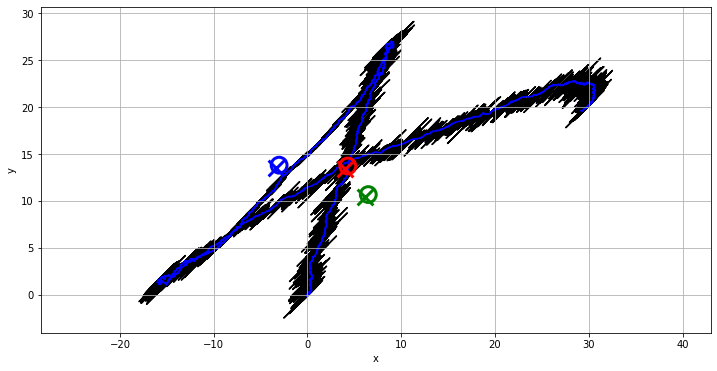

In [ ]:
x1, x2, y1, y2, sb, L_x, L_y, o_v = f_Simulate_1(tf,dt,dim,n_s,n_l,m,q,r)
f_Plot_Trajectory_1(x1,x2,y1,y2,sb,L_x,L_y)

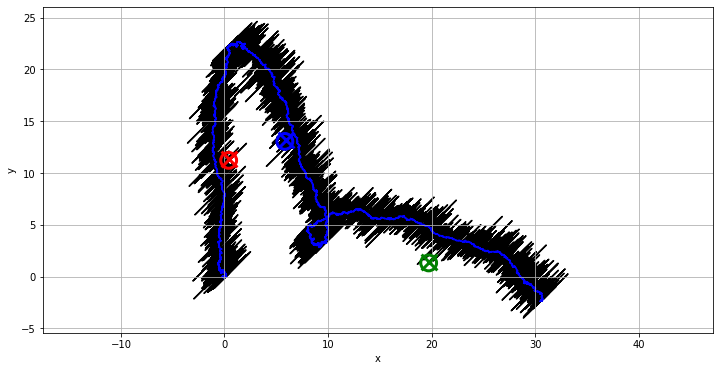

In [ ]:
x1, x2, y1, y2, sb, L_x, L_y, o_v = f_Simulate_1(tf,dt,dim,n_s,n_l,m,q,r)
f_Plot_Trajectory_1(x1,x2,y1,y2,sb,L_x,L_y)

## Part II


The landmarks aren't moving, so propagating their positions through the dynamical equations at every time step is a waste. Instead, we can treat them as a constraint in the output equation.

Here, we alternate a Kalman filter on the state and an MLE estimation of $ \lambda $ (see Part III for a derivation).

Consider the dynamical system:
$$ s_{t+1|t} = F s_{t|t}+ B u_t + w_t $$
$$ w_t \sim N(0,Q) $$
$$ o_t = H s_t + J \lambda + v_t $$
$$ v_t \sim N(0,R) $$

Our update equations are: \\

MLE on $ \lambda $:
$$ T (J^T J + J J^T) \bar{\lambda} + 2 \sum_{t=1}^T (J^T (H \bar{s}_t - o_t)) = 0 $$

Kalman filter updates: \\
$$ \bar{s}_{t+1|t} = F \bar{s}_{t|t} + Bu_t $$
$$ \Sigma_{t+1|t} = F\Sigma_{t|t}F^T + Q $$
$$ \bar{s}_{t+1|t+1} = F\bar{s}_{t+1|t}+ K_{t+1}(o_{t+1}- H \bar{s}_{t+1|t} - J\bar{\lambda}) $$
$$ \Sigma_{t+1|t+1} = (I - K_{t+1}H) \Sigma_{t+1|t} $$
$$ K_{t+1} = \Sigma_{t+1|t}H^T(H\Sigma_{t+1|t}H^T + R)^{-1} $$

In [ ]:
# Constants
tf = 5 # End time (starting at t=0)
dt = 0.001 # Time step size

m = 1 # Robot mass
n_l = 3 # Number of landmarks
n_s = 4 # Number of states

q = np.array((1,1/10,1,1/10))/50 # Process noise
r = 1/50 # Observation noise

In [ ]:
# Matrices in system and observation dynamics
def f_Dynamics_2(dt,n_s,n_l,m,q,r):
  # State matrix:
  F = np.matrix([[1,dt,0,0],[0,1,0,0],[0,0,1,dt],[0,0,0,1]])
  # Input matrix:
  B = np.matrix([[0,dt/m,0,0],[0,0,dt/m,0]]).T

  # Observation matrices:
  # (we observe the x and y displacements from our current position to each landmark)
  H = np.matrix([[1,0,0,0],[0,0,1,0],[1,0,0,0],[0,0,1,0],[1,0,0,0],[0,0,1,0]])
  J = -np.identity(n_l*2)

  # Process noise:
  q = np.array((1,1/10,1,1/10))/50
  Q = np.matrix([[q[0]**2,0,0,0],[0,q[1]**2,0,0],[0,0,q[2]**2,0],[0,0,0,q[3]**2]])
  # Observation noise:
  r = 1/50
  R = np.identity(n_l*2)*r**2

  # Initialize uncertainty matrix:
  Sigma = np.zeros((n_s,n_s))

  return F, B, H, J, Q, R, Sigma

In [ ]:
# Computes a Kalman Filter update
def f_Kalman_Filter_2(F,B,H,J,Q,R,u,o,sb,Sigma,n_s,Lambd_b):
  # A priori updates:
  sb = np.matmul(F,sb) + np.matmul(B,u)
  Sigma = np.matmul(np.matmul(F,Sigma),F.T) + Q
  # A posteriori updates:
  K = np.matmul(np.matmul(Sigma,H.T),np.linalg.inv(np.matmul(np.matmul(H,Sigma),H.T) + R)) # Kalman gain
  sb = np.matmul(F,sb) + np.matmul(K,(o - np.matmul(H,sb) - np.matmul(J,Lambd_b)))
  Sigma = np.matmul((np.identity(n_s) - np.matmul(K,H)),Sigma)
  return sb, Sigma

In [ ]:
# MLE of Lambda:
def f_Lambda_MLE(t,J,H,o_v,sb_v):
  LHS = np.linalg.inv(np.matmul(J.T,J) + np.matmul(J,J.T))
  RHS = 2*np.sum(np.matmul(J.T,o_v[:,0:t+1] - np.matmul(H,sb_v[:,0:t+1])),axis=1)/(t+1)
  Lambda_b = np.matmul(LHS,RHS)
  return Lambda_b

In [ ]:
# Solves the equations of motion
def f_Simulate_2(tf,dt,n_s,n_l,m,q,r):
  
  T = int(tf/dt) # Number of time steps
  tvec = np.arange(T+1) # Vector of time steps

  # Initializations
  x1 = np.zeros((T+1))
  x2 = np.zeros((T+1))
  y1 = np.zeros((T+1))
  y2 = np.zeros((T+1))
  u1 = np.zeros((T+1))
  u2 = np.zeros((T+1))

  # Create random landmarks:
  # Lambd = np.random.uniform(-10,10,6)
  L_x = np.random.uniform(-10,20,3)
  L_y = np.random.uniform(-5,15,3)
  Lambd = np.matrix((L_x[0],L_y[0],L_x[1],L_y[1],L_x[2],L_y[2])).T

  # Initial state:
  s = np.zeros((n_s,1))

  sb_v = np.zeros((n_s,T+1)) # Array of state estimates
  sb = np.zeros((n_s,1)) # Initial state estimate

  o_v = np.zeros((n_l*2,T)) # Array of observations

  u_v = np.zeros((2,T+1)) # Array of control inputs
  
  # Matrices in dynamic equations
  F, B, H, J, Q, R, Sigma = f_Dynamics_2(dt,n_s,n_l,m,q,r)

  Lambd_b = Lambd + np.random.normal(r) # Initial measurement of landmarks

  # Solve the difference equations:
  # Since we compute the (i+1)th outputs at state i, stop one step early.
  for t in tvec[0:-1]:

    # # Move in an ellipse:
    # u1[t] = 5 - x1[t]
    # u2[t] = 5 - y1[t]
    # if t < 100:
    #   u1[t] += 70
    #   u2[t] += 10

    # Move to each of the points:
    i = int(t/(T/3))
    u1[t] = -(sb[0] - Lambd_b[2*i])
    u2[t] = -(sb[2] - Lambd_b[2*i+1])

    u = np.matrix((u1[t],u2[t])).T # Input vector
    u_v[:,t] = np.squeeze(np.array(u)) # Append observation to array

    # Difference Equations
    x1[t+1] = x1[t] + dt*x2[t] + np.random.normal(0,q[0])
    x2[t+1] = x2[t] + (dt/m)*u1[t] + np.random.normal(0,q[1])
    y1[t+1] = y1[t] + dt*y2[t] + np.random.normal(0,q[2])
    y2[t+1] = y2[t] + (dt/m)*u2[t] + np.random.normal(0,q[3])

    # Update state vector:
    s[0] = x1[t+1]
    s[1] = x2[t+1]
    s[2] = y1[t+1]
    s[3] = y2[t+1]

    o = np.matmul(H,s) + np.matmul(J,Lambd) + np.random.normal(r) # Observation
    o_v[:,t] = np.squeeze(np.array(o)) # Append observation to array

    Lambd_b = f_Lambda_MLE(t,J,H,o_v,sb_v) # MLE update
    sb, Sigma = f_Kalman_Filter_2(F,B,H,J,Q,R,u,o,sb,Sigma,n_s,Lambd_b) # Kalman filter update
    sb_v[:,t+1] = np.squeeze(np.array(sb)) # Append estimated state to array
  
  return x1, x2, y1, y2, sb_v, np.array(Lambd), np.array(Lambd_b), o_v, u_v

In [ ]:
# Plot the trajectory
def f_Plot_Trajectory_2(x1,x2,y1,y2,sb_v,Lambd,Lambd_b):
  c = ['r','b','g']
  plt.plot(sb_v[0,:],sb_v[2,:],color='k',zorder=1)
  plt.plot(x1,y1,color='b',zorder=1)
  for i in np.arange(n_l):
    plt.scatter(Lambd[2*i],Lambd[2*i+1],color=c[i],s=250,marker='o',facecolors='none',linewidth=3,zorder=2)
    plt.scatter(Lambd_b[2*i],Lambd_b[2*i+1],color=c[i],s=250,marker='x',linewidth=3,zorder=2)
  rcParams['figure.figsize'] = 12, 6
  plt.xlabel('x')
  plt.ylabel('y')
  plt.grid()
  plt.axis('equal')
  plt.show()

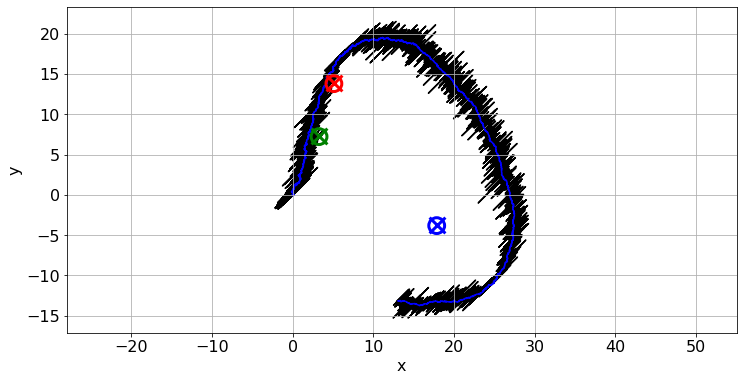

In [ ]:
x1, x2, y1, y2, sb_v, Lambd, Lambd_b, o_v, u_v = f_Simulate_2(tf,dt,n_s,n_l,m,q,r)
f_Plot_Trajectory_2(x1,x2,y1,y2,sb_v,Lambd,Lambd_b)

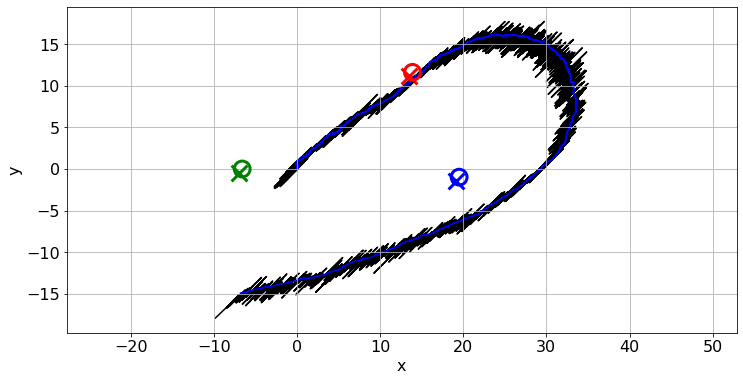

In [ ]:
x1, x2, y1, y2, sb_v, Lambd, Lambd_b, o_v, u_v = f_Simulate_2(tf,dt,n_s,n_l,m,q,r)
f_Plot_Trajectory_2(x1,x2,y1,y2,sb_v,Lambd,Lambd_b)

## Part III

Consider again the dynamical system:

$$ s_{t+1|t} = F s_{t|t}+ B u_t + w_t $$
$$ w_t \sim N(0,Q) $$
$$ o_t = H s_t + J \lambda + v_t $$
$$ v_t \sim N(0,R) $$
where $ s \in R^{N_{s}} $ represents a robot's position and velocity, and $\lambda \in R^{N_{\lambda}} $ is a vector of landmark positions.

Here, we compute the MLE of the joint probability distribution of the state vector and the landmark vector. That is, $ (\hat{s}_{0:T},\hat{\lambda}) = \mathrm{argmax}_{s_{0:T},\lambda} \mathcal{L} \\
= \mathrm{argmax}_{s_{0:T},\lambda} \log p(s_{0:T},o_{1:T}|u_{0:T-1},\lambda) $ \\
$ = \mathrm{argmax}_{s_{0:T},\lambda} (\sum_{t=0}^{T-1} \log p(s_{t+1}|s_t,u_t) + \sum_{t=1}^T \log p(o_t|s_t,\lambda)) $ \\
$ = \mathrm{argmin}_{s_{0:T},\lambda} \sum_{t=0}^{T-1} (||s_{t+1} - f(s_t,u_t)||_2^2 + \sum_{t=1}^T ||o_t - h(s_t,\lambda)||_2^2) $ \\
$ = \mathrm{argmin}_{s_{0:T},\lambda} (\sum_{t=0}^{T-1} [s_{t+1} - (F s_t + B u_t)]^T[s_{t+1} - (F s_t + B u_t)] + \sum_{t=1}^T [o_t - (H s_t + J\lambda)]^T[o_t - (H s_t + J\lambda)]) $ \\
$ = \mathrm{argmin}_{s_{0:T},\lambda} (\sum_{t=0}^{T-1} [s_{t+1}^T s_{t+1} + (F s_t + B u_t)^T (F s_t + B u_t) - s_{t+1}^T (F s_t + B u_t) - (F s_t + B u_t)^T s_{t+1}] + \sum_{t=1}^T [o_t^T o_t + (H s_t + J\lambda)^T(H s_t + J \lambda) - o_t^T (H s_t + J \lambda) - (H s_t + J\lambda)^T o_t]) $ \\
$ = \mathrm{argmin}_{s_{0:T},\lambda} (\sum_{t=0}^{T-1} [s_{t+1}^T s_{t+1} + s_t^T F^T F s_t + u_t^T B^T F s_t + s_t^T F^T B u_t + u_t^T B^T B u_t - s_{t+1}^T F s_t - s_{t+1}^T B u_t - s_t^T F^T s_{t+1} - u_t^T B^T s_{t+1}] + \sum_{t=1}^T [o_t^T o_t + s_t^T H^T H s_t  + \lambda^T J^T H s_t + s_t^T H^T J \lambda + \lambda^T J^T J \lambda - o_t^T H s_t - o_t^T J \lambda - s_t^T H^T o_t - \lambda^T J^T o_t]) $ \\
$ = \mathrm{argmin}_{s_{0:T},\lambda} (\sum_{t=0}^{T-1} [s_{t+1}^T s_{t+1} + s_t^T F^T F s_t + u_t^T B^T F s_t + s_t^T F^T B u_t + u_t^T B^T B u_t - s_{t+1}^T F s_t - s_{t+1}^T B u_t - s_t^T F^T s_{t+1} - u_t^T B^T s_{t+1} + s_{t+1}^T H^T H s_{t+1}  + \lambda^T J^T H s_{t+1} + s_{t+1}^T H^T J \lambda + \lambda^T J^T J \lambda - o_{t+1}^T H s_{t+1} - o_{t+1}^T J \lambda - s_{t+1}^T H^T o_{t+1} - \lambda^T J^T o_{t+1}]) $ \\
$ = \mathrm{argmin}_{s_{0:T},\lambda} (\sum_{t=0}^{T-1} [s_{t+1}^T (I + H^T H) s_{t+1} + s_t^T F^T F s_t + 2 u_t^T B^T F s_t - 2 s_t^T F^T s_{t+1}- 2 u_t^T B^T s_{t+1} + 2 \lambda^T J^T H s_{t+1} + \lambda^T J^T J \lambda - 2 o_{t+1}^T H s_{t+1} - 2 \lambda^T J^T o_{t+1}]) $ \\
(Note that the cross terms are transposes of each other and they are scalars, so they are equal.) \\

For optimality, we need $ \frac{\partial{\mathcal{L}}}{\partial \lambda} = 0 $ and $ \frac{\partial{\mathcal{L}}}{\partial s_i} = 0, \forall i \in [0,T] $. Thus, for optimal $ \lambda $ and $ s_{0:T} $, \\
$ \frac{\partial{\mathcal{L}}}{\partial \lambda} \sum_{t=0}^{T-1} (2 \lambda^T J^T H s_{t+1} + \lambda^T J^T J \lambda - 2 \lambda^T J^T o_{t+1}) = 0 $ \\
$ \Rightarrow \sum_{t=0}^{T-1} \frac{\partial{\mathcal{L}}}{\partial \lambda} (2 \lambda^T J^T H s_{t+1} + \lambda^T J^T J \lambda - 2 \lambda^T J^T o_{t+1}) = 0 $ \\
$ \Rightarrow \sum_{t=0}^{T-1} (J^T J + J J^T) \hat{\lambda} + 2 J^T (H \hat{s}_{t+1} - o_{t+1})) = 0 $ \\
$ \Rightarrow T (J^T J + J J^T) \hat{\lambda} + 2 \sum_{t=1}^T (J^T (H \hat{s}_t - o_t)) = 0 $ \\

And, \\
$ \frac{\partial{\mathcal{L}}}{\partial s_0} (s_0^T F^T F s_0 + 2 u_0^T B^T F s_0 - 2 s_0^T F^T s_1 ) = 0 $ \\
$ \frac{\partial{\mathcal{L}}}{\partial s_t} ([s_t^T (I + H^T H) s_t - 2 s_{t-1}^T F^T s_t- 2 u_{t-1}^T B^T s_t + 2 \lambda^T J^T H s_t - 2 o_t^T H s_t] + [s_t^T F^T F s_t + 2 u_t^T B^T F s_t - 2 s_t^T F^T s_{t+1}]) = 0 , \forall t \in [1,T-1] $ \\
$ \frac{\partial{\mathcal{L}}}{\partial s_T} [s_T^T (I + H^T H) s_T - 2 s_{T-1}^T F^T s_T - 2 u_{T-1}^T B^T s_T + 2 \lambda^T J^T H s_T - 2 o_T^T H s_T] = 0 $ \\

Thus, \\
$ (F^T F + F F^T)\hat{s}_0 + 2 F^T B u_0 - 2 F^T \hat{s}_1 = 0 $ \\
$ [2(I + H^T H) \hat{s}_t - 2 F \hat{s}_{t-1} - 2 B u_{t-1} + 2 H^T J \hat{\lambda} - 2 H^T o_t] + [(F^T F + F F^T) \hat{s}_t  + 2 F^T B u_t - 2 F^T \hat{s}_{t+1}] = 0 , \forall t \in [1,T-1] $ \\
$ 2(I + H^T H) \hat{s}_T - 2 F \hat{s}_{T-1} - 2 B u_{T-1} + 2 H^T J \hat{\lambda} - 2 H^T o_T = 0 $ \\

Thus, we have a system of $ (T+1) N_S + N_{\lambda} $ linear equations in $ (T+1) N_S + N_{\lambda} $ unknowns: \\
$$ \frac{1}{2}(J^T J + J J^T) \hat{\lambda} + \frac{1}{T} \sum_{t=1}^T (J^T (H \hat{s}_t - o_t)) = 0 $$
$$ \frac{1}{2}(F^T F + F F^T)\hat{s}_0 + F^T B u_0 - F^T \hat{s}_1 = 0 $$
$$ [(I + H^T H) \hat{s}_t - F \hat{s}_{t-1} - B u_{t-1} + H^T J \hat{\lambda} - H^T o_t] + [\frac{1}{2}(F^T F + F F^T) \hat{s}_t  + F^T B u_t - F^T \hat{s}_{t+1}] = 0 , \forall t \in [1,T-1] $$
$$ (I + H^T H) \hat{s}_T - F \hat{s}_{T-1} - B u_{T-1} + H^T J \hat{\lambda} - H^T o_T = 0 $$

Let $M$ = 
$ \begin{bmatrix}
\frac{1}{2}(J^T J + J J^T) & 0^{N_{\lambda} \times N_s} & \frac{1}{T} J^T H & \cdots & \cdots & \cdots & \frac{1}{T} J^T H \\
0^{N_s \times N_{\lambda}} & \frac{1}{2}(F^T F + F F^T) & - F^T & 0^{N_s \times N_s} & 0^{N_s \times N_s} & \cdots & 0^{N_s \times N_s} \\
\frac{1}{T} H^T J & - F & (I + H^T H)  + \frac{1}{2}(F^T F + F F^T) & -F^T  & 0^{N_s \times N_s} & \cdots & 0^{N_s \times N_s} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\frac{1}{T} H^T J & 0^{N_s \times N_s} & \cdots & 0^{N_s \times N_s} & -F &(I + H^T H)  + \frac{1}{2}(F^T F + F F^T) & -F^T  \\
\frac{1}{T} H^T J & 0^{N_s \times N_s} & 0^{N_s \times N_s} & 0^{N_s \times N_s} & 0^{N_s \times N_s} & -F & (I + H^T H)
\end{bmatrix} $ \\

let $C$ = 
$ \begin{bmatrix}
\frac{1}{T} \sum_{t=1}^T J^T o_t \\
-F^T B u_0 \\
B u_0 + H^T o_1 - F^T B u_1 \\
\vdots \\
B u_{t-1} + H^T o_t - F^T B u_t \\
\vdots \\
B u_{T-2} + H^T o_{T-1} - F^T B u_{T-1} \\
B u_{T-1} + H^T o_T
\end{bmatrix} $, and let $ \hat{S} = $
$ \begin{bmatrix}
\hat{\lambda} \\
\hat{s}_0 \\
\hat{s}_1 \\
\vdots \\
\hat{s}_t \\
\vdots \\
\hat{s}_T
\end{bmatrix} $.

Then the system of equations can be rewritten as $ M \hat{S} = C $. Thus, the MLE (assuming it exists) is $ \hat{S} = M^{-1} C $. The least squares solution is $ \hat{S} = (M^T M)^{-1} M^T C $.



In [ ]:
tf = 1/10
T = int(tf/dt) # Number of time steps

F, B, H, J, _, _, _ = f_Dynamics_2(dt,n_s,n_l,m,q,r)
x1, x2, y1, y2, sb_v, Lambd, Lambd_b, o_v, u_v = f_Simulate_2(tf,dt,n_s,n_l,m,q,r)

JJ_JJ = (np.matmul(J.T,J) + np.matmul(J,J.T))/2
JH = np.matmul(J.T,H)/T
FF_FF = (np.matmul(F.T,F) + np.matmul(F,F.T))/2
I_HH = (np.identity(n_s) + np.matmul(H.T,H))

sz = 2*n_l + n_s*(T+1)
M = np.zeros((sz,sz))

len = n_s+2*n_l
L = T*n_s+2*n_l
M[0:2*n_l,len+0*n_s:len+0*n_s+n_s] = JH
for i in np.arange(T-1):
  M[0:2*n_l,len+i*n_s:len+i*n_s+n_s] = JH
M[0:2*n_l,0:2*n_l] = np.matmul(J.T,J)/2
M = M+M.T
M[n_s:2*n_s,2*n_l:2*n_l+n_s] = FF_FF
M[n_s:2*n_s,2*n_l+n_s:2*n_l+2*n_s] = -F.T
M[L-n_s:L,L-n_s:L] = I_HH
M[L-n_s:L,L-2*n_s:L-n_s] = -F

vec = np.concatenate((-F,I_HH + FF_FF),axis=1)
vec = np.concatenate((vec,-F.T),axis=1)

for i in np.arange(T-1):
  M[n_s+2*n_l+i*n_s:n_s+2*n_l+i*n_s+n_s, i*n_s+2*n_l:i*n_s+3*n_s+2*n_l] = vec

In [ ]:
ov = np.concatenate((np.zeros((n_l*2,1)),o_v),axis=1)
uv = u_v[:,0:T]
c1 = 2*np.matrix(np.sum(np.matmul(J.T,ov),axis=1)).T/T
Bu = np.matmul(B,uv)
FBu = np.matmul(F.T,Bu)
Ho = np.matmul(H.T,ov)
c2 = - 2*FBu[:,0]
c3 = 2*Bu[:,0:T-1] + 2*Ho[:,1:T] - 2*FBu[:,1:T]
c4 = 2*Bu[:,T-1] + 2*Ho[:,T]

C1 = np.concatenate((c1,c2),axis=0)
C2 = np.concatenate((np.matrix.flatten(c3).T,c4),axis=0)
C = np.concatenate((C1,C2))

In [ ]:
M_inv = np.matmul(np.linalg.inv(np.matmul(M.T,M)),M.T)

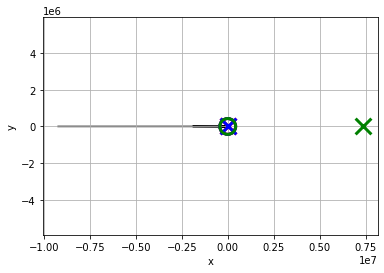

In [ ]:
S_hat = np.squeeze(np.array(np.matmul(M_inv,C)))
Lambd_hat = S_hat[0:2*n_l]
s_hat = S_hat[2*n_l:2*n_l+(T+1)*n_s]
s_hat = np.reshape(s_hat,newshape=(n_s,T+1))
f_Plot_Trajectory_2(x1,x2,y1,y2,s_hat,Lambd,Lambd_hat)

This doesn't work, and it's very slow because it involves inverting a large matrix.

Rather than solving this (potentially very large) system of equations, let us alternate between updating the state and the landmark estimates.

In [ ]:
def f_MLE_mat(F,H,B,u_1,n_s):
  FF_FF = np.matmul(F.T,F) + np.matmul(F,F.T)
  I_HH = (np.identity(n_s) + np.matmul(H.T,H))
  I_HH_FF_FF = 2*I_HH + FF_FF
  FB = np.matmul(F.T,B)
  FT_inv = np.linalg.inv(F.T)
  I_HH_inv = np.linalg.inv(I_HH)
  return FF_FF, I_HH_FF_FF, FB, FT_inv, I_HH_inv

In [ ]:
def f_State_MLE(B,H,J,FF_FF,I_HH_FF_FF,FB,FT_inv,I_HH_inv,u_1,u,o,s_hat_2,s_hat_1,s_hat,n_s,Lambd_hat,t):
  Bu = np.matmul(B,u_1)
  FBu = np.matmul(FB,u)
  Ho = np.matmul(H.T,o)
  HJlambd = np.matmul(np.matmul(H.T,J),Lambd_hat)

  s_hat_2 = s_hat_1
  s_hat_1 = s_hat
  if t == 0:
    s_hat = np.matmul(FT_inv,np.matmul(FF_FF,s_hat_1)/2 + FBu)
  elif t == T:
    s_hat = np.matmul(I_HH_inv,np.matmul(F,s_hat_1) + Bu - HJlambd + Ho)
  else:
    s_hat = np.matmul(FT_inv,np.matmul(I_HH,s_hat_1) - np.matmul(F,s_hat_2) - Bu + HJlambd - Ho + np.matmul(FF_FF,s_hat_1)/2 + FBu)

  return s_hat_2,s_hat_1,s_hat

In [ ]:
# Solves the equations of motion
def f_Simulate_3(tf,dt,n_s,n_l,m,q,r):
  
  T = int(tf/dt) # Number of time steps
  tvec = np.arange(T+1) # Vector of time steps

  # Initializations
  x1 = np.zeros((T+1))
  x2 = np.zeros((T+1))
  y1 = np.zeros((T+1))
  y2 = np.zeros((T+1))
  u1 = np.zeros((T+1))
  u2 = np.zeros((T+1))

  # Create random landmarks:
  # Lambd = np.random.uniform(-10,10,6)
  L_x = np.random.uniform(-10,20,3)
  L_y = np.random.uniform(-5,15,3)
  Lambd = np.matrix((L_x[0],L_y[0],L_x[1],L_y[1],L_x[2],L_y[2])).T

  # Initial state:
  s = np.zeros((n_s,1))

  s_hat_2 = np.zeros((n_s,1)) # Initialize state estimate at time t-2
  s_hat_1 = np.zeros((n_s,1)) # Initialize state estimate at time t-1
  s_hat = np.zeros((n_s,1)) # Initial state estimate
  u_1 = np.matrix((0,0)).T # Initialize input vector at time t-1

  s_hat_v = np.zeros((n_s,T+1)) # Array of state estimates
  o_v = np.zeros((n_l*2,T)) # Array of observations
  u_v = np.zeros((2,T+1)) # Array of control inputs

  # Matrices in dynamic equations
  F, B, H, J, _, _, _ = f_Dynamics_2(dt,n_s,n_l,m,q,r)
  FF_FF, I_HH_FF_FF, FB, FT_inv, I_HH_inv = f_MLE_mat(F,H,B,u_1,n_s)

  Lambd_hat = Lambd + np.random.normal(r) # Initial measurement of landmarks

  # Solve the difference equations:
  # Since we compute the (i+1)th outputs at state i, stop one step early.
  for t in tvec[0:-1]:

    # Move in an ellipse:
    u1[t] = 5 - x1[t]
    u2[t] = 5 - y1[t]
    if t < 100:
      u1[t] += 70
      u2[t] += 10

    # # Move to each of the points:
    # i = int(t/(T/3))
    # u1[t] = -(s[0] - Lambd[2*i])
    # u2[t] = -(s[2] - Lambd[2*i+1])

    u = np.matrix((u1[t],u2[t])).T # Input vector
    u_v[:,t] = np.squeeze(np.array(u)) # Append observation to array

    # Difference Equations
    x1[t+1] = x1[t] + dt*x2[t] + np.random.normal(0,q[0])
    x2[t+1] = x2[t] + (dt/m)*u1[t] + np.random.normal(0,q[1])
    y1[t+1] = y1[t] + dt*y2[t] + np.random.normal(0,q[2])
    y2[t+1] = y2[t] + (dt/m)*u2[t] + np.random.normal(0,q[3])

    # Update state vector:
    s[0] = x1[t+1]
    s[1] = x2[t+1]
    s[2] = y1[t+1]
    s[3] = y2[t+1]

    o = np.matmul(H,s) + np.matmul(J,Lambd) + np.random.normal(r) # Observation
    o_v[:,t] = np.squeeze(np.array(o)) # Append observation to array

    # MLE update of lambda:
    Lambd_hat = f_Lambda_MLE(t,J,H,o_v,s_hat_v)
    # MLE update of the state:
    s_hat_2,s_hat_1,s_hat = f_State_MLE(B,H,J,FF_FF,I_HH_FF_FF,FB,FT_inv,I_HH_inv,u_1,u,o,s_hat_2,s_hat_1,s_hat,n_s,Lambd_hat,t)
    
    u_1 = u # Update control input at time t-1
    s_hat_v[:,t+1] = np.squeeze(np.array(s_hat)) # Append estimated state to array
  
  return x1, x2, y1, y2, s_hat_v, np.array(Lambd), np.array(Lambd_hat), o_v, u_v

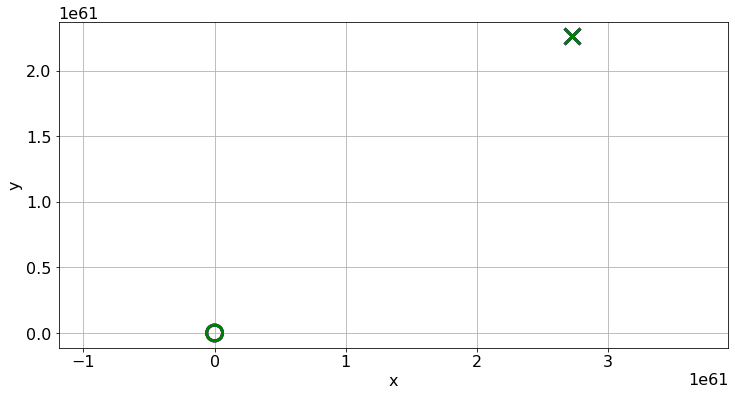

In [ ]:
tf = dt*100
x1, x2, y1, y2, s_hat_v, Lambd, Lambd_hat, o_v, u_v = f_Simulate_3(tf,dt,n_s,n_l,m,q,r)
f_Plot_Trajectory_2(x1,x2,y1,y2,s_hat_v,Lambd,Lambd_hat)

# print(s_hat_v)
# print(np.array((x1, x2, y1, y2)))
# t

This seems to diverge...